# Healthcare No Show Data Analysis (CSV)

Script for analysis of healthcare no show data from a CSV file.

The data used can be found from [Kaggle Healthcare Dataset](https://www.kaggle.com/datasets/joniarroba/noshowappointments).

In [1]:
import sys
sys.path.append("../..")  # add src to path to import custom modules

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from src.plotting import plot_grouped_bar, plot_stacked_bar

Configurations

In [2]:
pd.set_option('display.expand_frame_repr', False)

## Understanding and preprocess the data

Read file.

In [3]:
file_path = "../../data/scheduling/KaggleV2-May-2016.csv"
pd_data = pd.read_csv(file_path)

Print raw content to see how the data looks like.

In [4]:
print(pd_data)

           PatientId  AppointmentID Gender          ScheduledDay        AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  SMS_received No-show
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1         0           0        0             0      No
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0         0           0        0             0      No
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0         0           0        0             0      No
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0         0           0        0             0      No
4       8.841186e+12        5642494      F  2

Check summary of the data.

In [5]:
print(pd_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


Observations:
1. No missing values.
2. Field names not following SQL naming convention.
3. Field names have spelling mistakes.

First phase data cleaning:
1. Change all fields to snake_case, following SQL naming convention.
2. Fix spelling mistakes.

In [6]:
# Rename field names
pd_data.rename(
    columns={
        'PatientId': 'patient_id',
        'AppointmentID': 'appointment_id',
        'Gender': 'gender',
        'ScheduledDay': 'scheduled_day',
        'AppointmentDay': 'appointment_day',
        'Age': 'age',
        'Neighbourhood': 'neighbourhood',
        'Scholarship': 'scholarship',
        'Hipertension': 'hypertension',
        'Diabetes': 'diabetes',
        'Alcoholism': 'alcoholism',
        'Handcap': 'handicap',
        'SMS_received': 'sms_received',
        'No-show': 'no_show'
}, inplace=True)

In [8]:
print(pd_data)

          patient_id  appointment_id gender         scheduled_day       appointment_day  age      neighbourhood  scholarship  hypertension  diabetes  alcoholism  handicap  sms_received no_show
0       2.987250e+13         5642903      F  2016-04-29T18:38:08Z  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1         0           0         0             0      No
1       5.589978e+14         5642503      M  2016-04-29T16:08:27Z  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0         0           0         0             0      No
2       4.262962e+12         5642549      F  2016-04-29T16:19:04Z  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0         0           0         0             0      No
3       8.679512e+11         5642828      F  2016-04-29T17:29:31Z  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0         0           0         0             0      No
4       8.841186e+12         564249

In [9]:
print(pd_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   patient_id       110527 non-null  float64
 1   appointment_id   110527 non-null  int64  
 2   gender           110527 non-null  object 
 3   scheduled_day    110527 non-null  object 
 4   appointment_day  110527 non-null  object 
 5   age              110527 non-null  int64  
 6   neighbourhood    110527 non-null  object 
 7   scholarship      110527 non-null  int64  
 8   hypertension     110527 non-null  int64  
 9   diabetes         110527 non-null  int64  
 10  alcoholism       110527 non-null  int64  
 11  handicap         110527 non-null  int64  
 12  sms_received     110527 non-null  int64  
 13  no_show          110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


## patient_id

IDs of the patients.

Checking:
1. Uniqueness (though it should be fine to not enforce uniqueness on this field)

In [10]:
patient_id = pd_data["patient_id"]
print("No. of unique IDs: %i" % len(patient_id.unique()))

No. of unique IDs: 62299


Observations:
1. 62299 unique values out of 110527 total rows. So, there are many returning patients. 

## appointment_id

IDs of the appointments.

Checking
1. Uniqueness (should be enforced)

In [11]:
appointment_id = pd_data["appointment_id"]
print("No. of unique IDs: %i" % len(appointment_id.unique()))

No. of unique IDs: 110527


Observations:
1. All appointment IDs are unique.

## no_show

If a patient missed the appointment (value = Yes) or attended the appointment (value = No).

Checking:
1. If values other than Yes/No are used
2. Yes/No ratio

In [12]:
no_show = pd_data["no_show"]
print("Values: %s" % str(no_show.unique()))

noshow_count = no_show.value_counts()
print(noshow_count)
print("False: %0.2f%%" % (noshow_count.loc["No"] / noshow_count.sum() * 100))
print("True: %0.2f%%" % (noshow_count.loc["Yes"] / noshow_count.sum() * 100))

Values: ['No' 'Yes']
no_show
No     88208
Yes    22319
Name: count, dtype: int64
False: 79.81%
True: 20.19%


Observations:
1. No unwanted value.
2. There are a lot more "No" than "Yes". Data is imbalanced.

## gender

"M" = Male

"F" = Female

Checking:
1. "M" and "F" only?
2. Data imbalance?
3. How does this field affect no_show?
    - Plot a bar chart
    - Null-hypothesis significance test - if male and female distributions are similar?

In [13]:
print(pd_data["gender"].unique())
pd_gender = pd_data[["gender", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_gender)

['F' 'M']
no_show     No    Yes
gender               
F        57246  14594
M        30962   7725


Observations:
1. Only "F" and "M".
2. Female is almost double of male, hence there is data imbalance issue.
3. Normalization needed for bar chart due to (2).

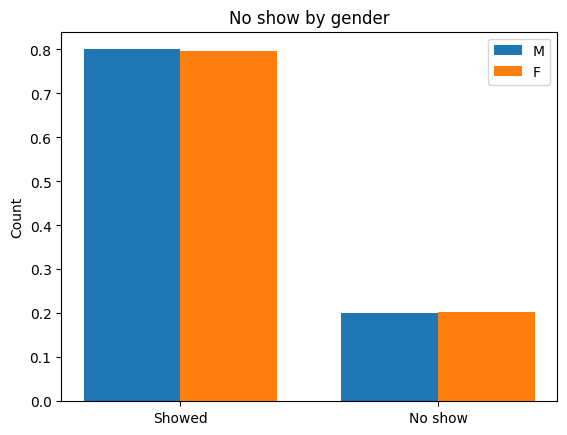

In [14]:
pd_m = pd_gender.loc["M"].to_numpy()
pd_f = pd_gender.loc["F"].to_numpy()
plot_grouped_bar([pd_m / pd_m.sum(), pd_f / pd_f.sum()],
                 "No show by gender",
                 group_labels=["Showed", "No show"],
                 category_labels=["M", "F"])

In [15]:
stat, p, dof, expected = chi2_contingency(np.array([pd_m, pd_f]))
print("p-value: %0.2f" % p)

p-value: 0.17


Observations for (3):
1. Visually, the distributions of male and female look similar. 
2. Statistically, p-value is not < 0.05, hence null hypothesis (h0) is accepted. So, there is no relationship between gender and no show.

## scheduled_day and appointment_day

These types of data usually don't help much. But, the following information can be extracted:
1. Lag days between the appointment day and scheduling day
2. Day of the week

Datetime preprocessing:
1. Convert to python datetime.
2. All appointment_day time are 00:00:00+00:00, which is noisy for analysis. So, time will be ignored.

In [16]:
scheduled = pd_data["scheduled_day"] = pd.to_datetime(pd_data["scheduled_day"]).dt.normalize()
appointment = pd_data["appointment_day"] = pd.to_datetime(pd_data["appointment_day"]).dt.normalize()

Checking:
1. If any lag days are negative.

In [17]:
lag_days = (appointment - scheduled).dt.days
print("No. of negative lag days: %i" % sum(lag_days < 0))

No. of negative lag days: 5


Observations:
1. There are negative lag days. Since there are only 5, will remove these data for more accurate analysis.

In [18]:
pd_data = pd_data[lag_days >= 0]
scheduled = pd_data["scheduled_day"]
appointment = pd_data["appointment_day"]
lag_days = (appointment - scheduled).dt.days
print("No. of negative lag days: %i" % sum(lag_days < 0))

No. of negative lag days: 0


Merge lag days with no show data.

In [19]:
lag_days = lag_days.to_frame("lag_days")
lag_days = lag_days.assign(no_show=pd_data["no_show"])
print(lag_days)

        lag_days no_show
0              0      No
1              0      No
2              0      No
3              0      No
4              0      No
...          ...     ...
110522        35      No
110523        35      No
110524        41      No
110525        41      No
110526        41      No

[110522 rows x 2 columns]


Group lag days into bins of [same day, 7 days, 14 days, 30 days, 60 days, 90 days, >90 days]. Then count.

In [20]:
ranges = {
    "same day": 0.99,
    "7 days": 7,
    "14 days": 14,
    "30 days": 30,
    "60 days": 60,
    "90 days": 90,
    ">90 days": 200
}
labels, bins = zip(*ranges.items())
lag_days["lag_days_bins"] = pd.cut(lag_days["lag_days"], bins=(0,)+bins, labels=labels, include_lowest=True)
print(lag_days)

        lag_days no_show lag_days_bins
0              0      No      same day
1              0      No      same day
2              0      No      same day
3              0      No      same day
4              0      No      same day
...          ...     ...           ...
110522        35      No       60 days
110523        35      No       60 days
110524        41      No       60 days
110525        41      No       60 days
110526        41      No       60 days

[110522 rows x 3 columns]


In [21]:
lag_days_count = lag_days[["lag_days_bins", "no_show"]].value_counts().unstack(fill_value=0)
print(lag_days_count)

no_show           No   Yes
lag_days_bins             
same day       36771  1792
7 days         24413  7772
14 days         8361  3664
30 days        11710  5661
60 days         5454  2829
90 days         1338   540
>90 days         161    56


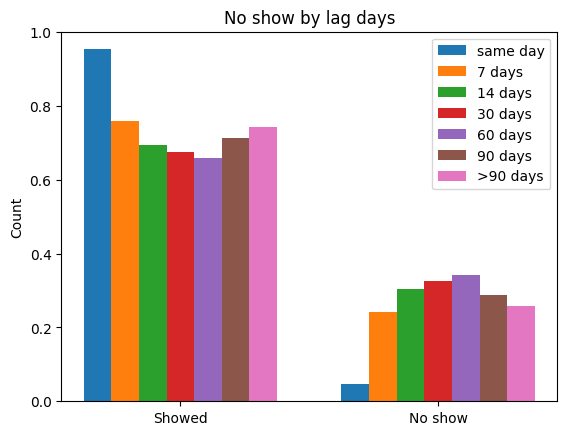

In [22]:
lag_days_data = lag_days_count.to_numpy()
lag_days_data_norm = np.array([x / x.sum() for x in lag_days_data])
plot_grouped_bar(lag_days_data_norm,
                 "No show by lag days",
                 group_labels=["Showed", "No show"],
                 category_labels=list(ranges.keys()))

In [23]:
stat, p, dof, expected = chi2_contingency(lag_days_data)
print("p-value: %f" % p)

p-value: 0.000000


Observations:
1. Statistically, p-value < 0.05. Hence, H0 is rejected, which means it is highly likely that there is relationship between lag days and no show.
2. Same day appointment no show rate is significantly lower than others.
3. There is evident that longer lag days will increase the chances of no show up to 60 days. 90 days and >90 days have significantly less data, hence could be less accurate at representing the real data of these groups.

Convert date to day of week.

In [24]:
dayofweek = appointment.dt.day_name()
print(dayofweek)

0          Friday
1          Friday
2          Friday
3          Friday
4          Friday
           ...   
110522    Tuesday
110523    Tuesday
110524    Tuesday
110525    Tuesday
110526    Tuesday
Name: appointment_day, Length: 110522, dtype: object


Merge with no show data and count.

In [25]:
dayofweek = dayofweek.to_frame("dayofweek")
dayofweek = dayofweek.assign(no_show=pd_data["no_show"])
print(dayofweek)

       dayofweek no_show
0         Friday      No
1         Friday      No
2         Friday      No
3         Friday      No
4         Friday      No
...          ...     ...
110522   Tuesday      No
110523   Tuesday      No
110524   Tuesday      No
110525   Tuesday      No
110526   Tuesday      No

[110522 rows x 2 columns]


In [26]:
dayofweek_count = dayofweek.value_counts().unstack(fill_value=0)
print(dayofweek_count)

no_show       No   Yes
dayofweek             
Friday     14982  4037
Monday     18025  4689
Saturday      30     9
Thursday   13909  3337
Tuesday    20488  5150
Wednesday  20774  5092


Reorder the days of the week, ignoring Sunday, since no one working on that day.

In [27]:
dayofweek_all = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
dayofweek_count = dayofweek_count.reindex(dayofweek_all, fill_value=0)
print(dayofweek_count)

no_show       No   Yes
dayofweek             
Monday     18025  4689
Tuesday    20488  5150
Wednesday  20774  5092
Thursday   13909  3337
Friday     14982  4037
Saturday      30     9


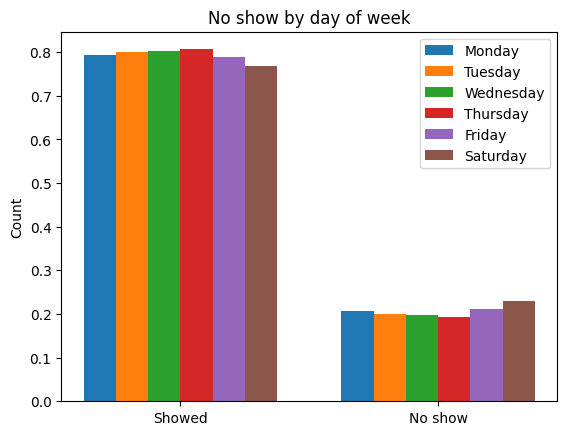

In [28]:
dayofweek_count_data = dayofweek_count.to_numpy()
dayofweek_count_data_norm = np.array([x / x.sum() for x in dayofweek_count_data])
plot_grouped_bar(dayofweek_count_data_norm,
                 "No show by day of week",
                 group_labels=["Showed", "No show"],
                 category_labels=dayofweek_all)

In [29]:
stat, p, dof, expected = chi2_contingency(dayofweek_count_data)
print("p-value: %f" % p)

p-value: 0.000044


Observations:
1. p-value < 0.05, hence it is very likely that there is relationship between day of week and no show.
2. It seems patients are less likely to miss the appointment at the middle of the week.

## age

The age of the patients.

In [30]:
pd_age = pd_data["age"]
print("No. of unique ages: %i" % len(pd_age.unique()))
print("Min age: %i" % pd_age.min())
print("Max age: %i" % pd_age.max())
print("Mean age: %0.2f" % pd_age.mean())
print("No. of negative age: %0.2f" % sum(pd_age < 0))

No. of unique ages: 104
Min age: -1
Max age: 115
Mean age: 37.09
No. of negative age: 1.00


Observations:
1. There is -1. According to the owner of the data, -1 means someone who is pregnant. This does not make sense as usually the age of the patient is recorded, not the fetus. Since there is only 1 such data, will be removed instead.

In [31]:
pd_data = pd_data[pd_age >= 0]
pd_age = pd_data["age"]
print("No. of unique ages: %i" % len(pd_age.unique()))
print("Min age: %i" % pd_age.min())
print("Max age: %i" % pd_age.max())
print("Mean age: %0.2f" % pd_age.mean())
print("No. of negative age: %0.2f" % sum(pd_age < 0))

No. of unique ages: 103
Min age: 0
Max age: 115
Mean age: 37.09
No. of negative age: 0.00


Group the ages and count.

In [32]:
age_ranges = {
    "Infant": 1,
    "Toddler": 4,
    "Child": 12,
    "Teen": 19,
    "Adult": 39,
    "Middle": 59,
    "Senior": 120
}
labels, bins = zip(*age_ranges.items())
age_group = pd_age.to_frame("age")
age_group = age_group.assign(no_show=pd_data["no_show"])
age_group["age_group"] = pd.cut(age_group["age"], bins=(0,)+bins, labels=labels, include_lowest=True)
print(age_group)

        age no_show age_group
0        62      No    Senior
1        56      No    Middle
2        62      No    Senior
3         8      No     Child
4        56      No    Middle
...     ...     ...       ...
110522   56      No    Middle
110523   51      No    Middle
110524   21      No     Adult
110525   38      No     Adult
110526   54      No    Middle

[110521 rows x 3 columns]


In [33]:
age_group_count = age_group[["age_group", "no_show"]].value_counts().unstack(fill_value=0)
print(age_group_count)

no_show       No   Yes
age_group             
Infant      4758  1054
Toddler     3619   811
Child       8352  2441
Teen        6941  2433
Adult      22190  6678
Middle     24416  5656
Senior     17931  3241


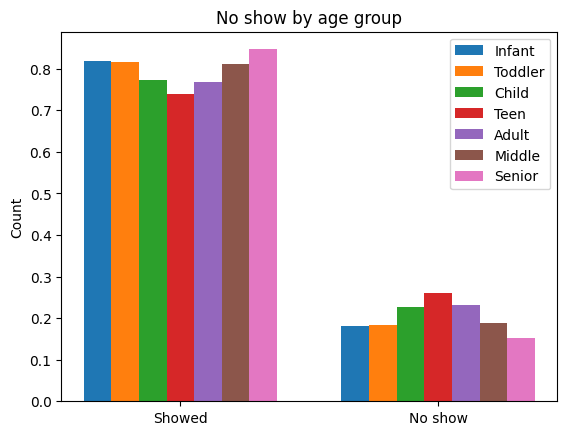

In [34]:
age_group_data = age_group_count.to_numpy()
age_group_data_norm = np.array([x / x.sum() for x in age_group_data])
plot_grouped_bar(age_group_data_norm,
                 "No show by age group",
                 group_labels=["Showed", "No show"],
                 category_labels=list(age_ranges.keys()))

In [35]:
stat, p, dof, expected = chi2_contingency(age_group_data)
print("p-value: %f" % p)

p-value: 0.000000


Observations:
1. p-value < 0.05, hence there are relationship between age and no show.
2. The groups in the middle (child, teen and adult) are more likely to miss the appointment.

## neighbourhood

Where are the patients live? Location of the clinic(s)? No clarification from the owner of the data.

In [36]:
pd_neighbourhood = pd_data[["neighbourhood", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_neighbourhood)

no_show                No  Yes
neighbourhood                 
AEROPORTO               7    1
ANDORINHAS           1741  521
ANTÔNIO HONÓRIO       221   50
ARIOVALDO FAVALESSA   220   62
BARRO VERMELHO        332   91
...                   ...  ...
SÃO JOSÉ             1549  428
SÃO PEDRO            1933  515
TABUAZEIRO           2559  572
UNIVERSITÁRIO         120   32
VILA RUBIM            710  141

[81 rows x 2 columns]


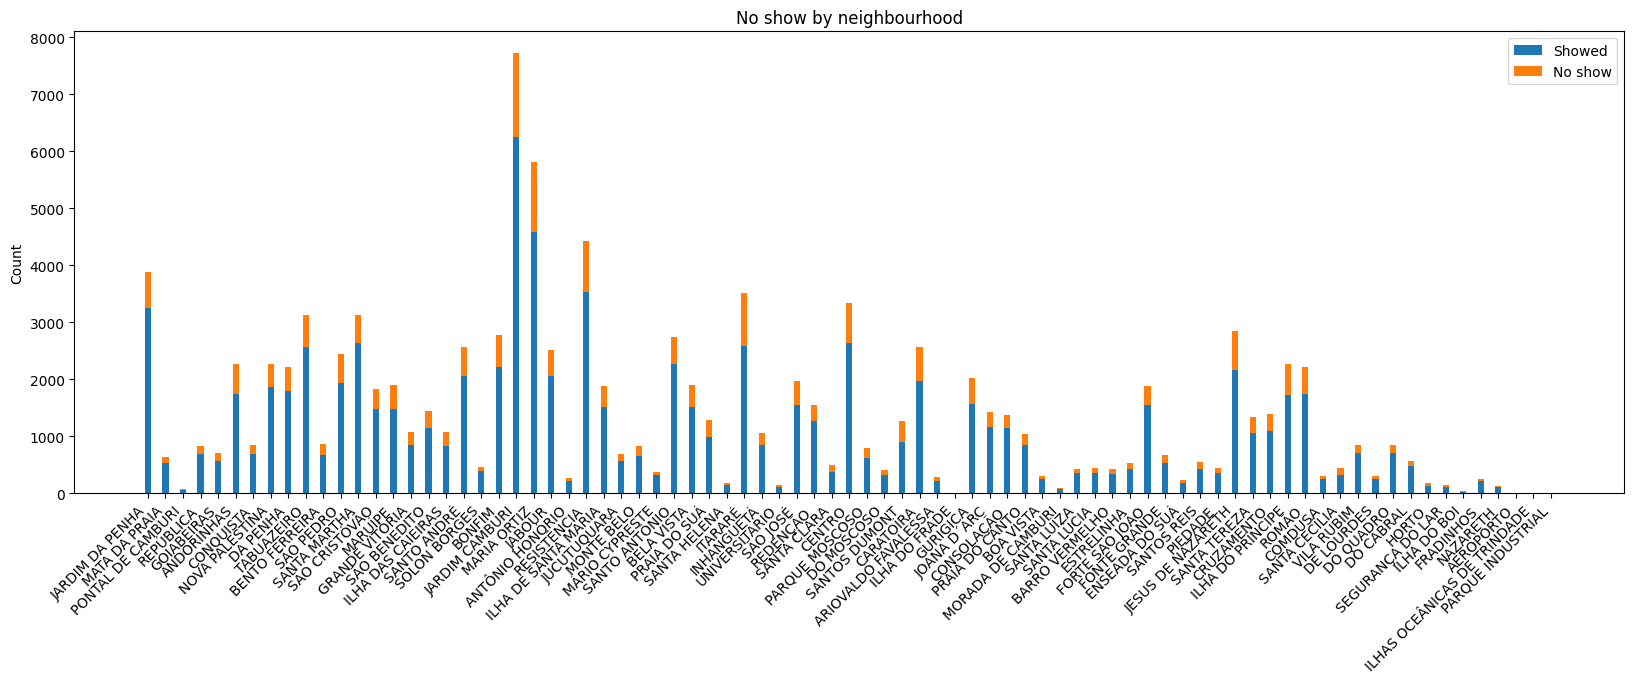

In [37]:
neighbourhood_labels = pd_data["neighbourhood"].unique()
data_neighbourhood = [pd_neighbourhood.loc[neighbourhood].to_numpy() for neighbourhood in neighbourhood_labels]
data_neighbourhood = np.array(data_neighbourhood).T
plot_stacked_bar(data_neighbourhood,
                 "No show by neighbourhood",
                 group_labels=neighbourhood_labels,
                 category_labels=["Showed", "No show"],
                 figsize=(20, 6),
                 rotate=45)

Discussions:
1. While we can plot some graphs, it is difficult to make any deduction from this kind of data.
2. The distance to the clinic from the patient's home is more useful. However, there is no such information or way to calculate it.
3. Other information such as the education level, household income, etc. of the patient that can be estimated based on this data might be useful.
4. Will be ignored for now.

## scholarship

Patient that is eligible to receive a scholarship, usually based on the household income. Hence, can be interpreted as if the patient belongs to low income group.

In [38]:
pd_scholarship = pd_data[["scholarship", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_scholarship)

no_show         No    Yes
scholarship              
0            79924  19736
1             8283   2578


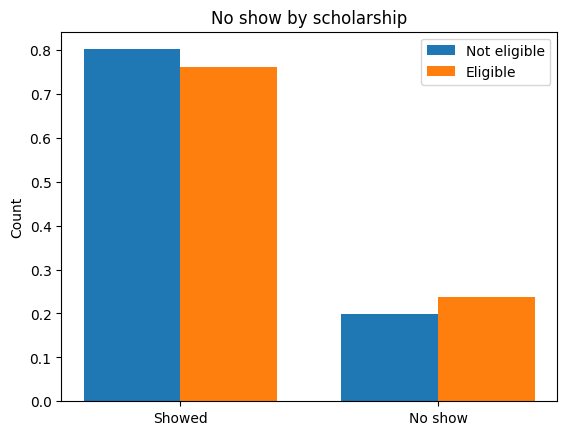

In [39]:
scholarship_data = pd_scholarship.to_numpy()
scholarship_data_norm = [x / x.sum() for x in scholarship_data]
plot_grouped_bar(scholarship_data_norm,
                 "No show by scholarship",
                 group_labels=["Showed", "No show"],
                 category_labels=["Not eligible", "Eligible"])

In [40]:
stat, p, dof, expected = chi2_contingency(scholarship_data)
print("p-value: %f" % p)

p-value: 0.000000


Observations:
1. Patients that are eligible for scholarship are slightly more likely to miss an appointment.

## hypertension

In [41]:
pd_hypertension = pd_data[["hypertension", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_hypertension)

no_show          No    Yes
hypertension              
0             70178  18542
1             18029   3772


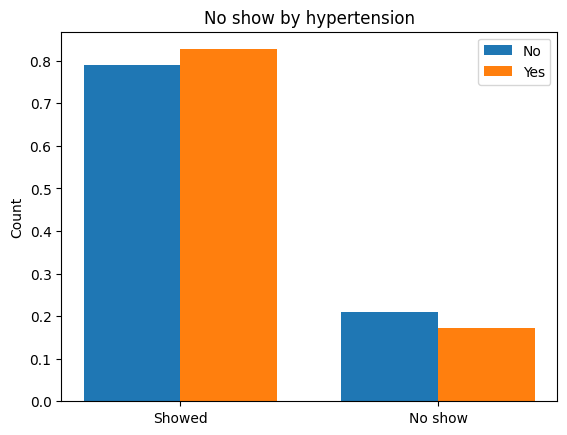

In [42]:
hypertension_data = pd_hypertension.to_numpy()
hypertension_data_norm = [x / x.sum() for x in hypertension_data]
plot_grouped_bar(hypertension_data_norm,
                 "No show by hypertension",
                 group_labels=["Showed", "No show"],
                 category_labels=["No", "Yes"])

In [43]:
stat, p, dof, expected = chi2_contingency(hypertension_data)
print("p-value: %f" % p)

p-value: 0.000000


Observations:
1. Patients with hypertension are slightly more likely to show up.

## diabetes

In [44]:
pd_diebetes = pd_data[["diabetes", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_diebetes)

no_show      No    Yes
diabetes              
0         81694  20884
1          6513   1430


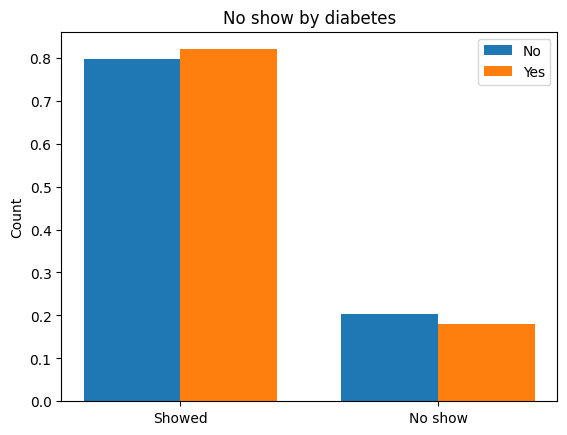

In [45]:
diebetes_data = pd_diebetes.to_numpy()
diebetes_data_norm = [x / x.sum() for x in diebetes_data]
plot_grouped_bar(diebetes_data_norm,
                 "No show by diabetes",
                 group_labels=["Showed", "No show"],
                 category_labels=["No", "Yes"])

In [46]:
stat, p, dof, expected = chi2_contingency(diebetes_data)
print("p-value: %f" % p)

p-value: 0.000001


Observations:
1. Patients with diebetes are slightly more likely to show up.

## alcoholism

In [47]:
pd_alcoholism = pd_data[["alcoholism", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_alcoholism)

no_show        No    Yes
alcoholism              
0           85524  21637
1            2683    677


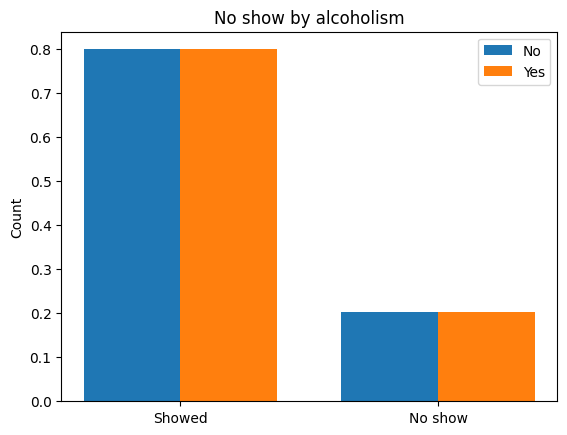

In [48]:
alcoholism_data = pd_alcoholism.to_numpy()
alcoholism_data_norm = [x / x.sum() for x in alcoholism_data]
plot_grouped_bar(alcoholism_data_norm,
                 "No show by alcoholism",
                 group_labels=["Showed", "No show"],
                 category_labels=["No", "Yes"])

In [49]:
stat, p, dof, expected = chi2_contingency(alcoholism_data)
print("p-value: %f" % p)

p-value: 0.969424


Observations:
1. p-value is not <0.05. Visually, it also shows that alcoholism has no relationship with no show.

## handicap

Handicap field is represented with number between 0 and 4, indicating the number of handicap a patient has.

In [50]:
pd_handicap = pd_data[["handicap", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_handicap)

no_show      No    Yes
handicap              
0         86373  21909
1          1676    364
2           146     37
3            10      3
4             2      1


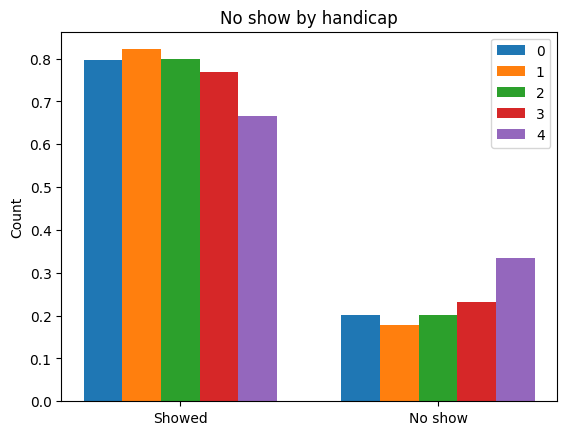

In [51]:
labels_handicap = pd_data["handicap"].unique()
handicap_data = pd_handicap.to_numpy()
handicap_data_norm = [x / x.sum() for x in handicap_data]
plot_grouped_bar(handicap_data_norm,
                 "No show by handicap",
                 group_labels=["Showed", "No show"],
                 category_labels=labels_handicap)

In [52]:
stat, p, dof, expected = chi2_contingency(handicap_data)
print("p-value: %f" % p)

p-value: 0.112251


Observations:
1. While the graph shows with more number of handicaps, higher chance of no show, except no handicap does not show same pattern.
2. p-value being not <0.05 also shows no relationship between handicap and no show rate.

Test with No handicap vs handicap instead:

In [53]:
handicap_ranges = {
    0: 0.99,
    1: 4
}
labels, bins = zip(*handicap_ranges.items())
handicap_group = pd_data["handicap"].to_frame("handicap")
handicap_group = handicap_group.assign(no_show=pd_data["no_show"])
handicap_group["handicap_group"] = pd.cut(handicap_group["handicap"], bins=(0,)+bins, labels=labels, include_lowest=True)
print(handicap_group)

        handicap no_show handicap_group
0              0      No              0
1              0      No              0
2              0      No              0
3              0      No              0
4              0      No              0
...          ...     ...            ...
110522         0      No              0
110523         0      No              0
110524         0      No              0
110525         0      No              0
110526         0      No              0

[110521 rows x 3 columns]


In [54]:
handicap_data = handicap_group[["handicap_group", "no_show"]].value_counts().unstack(fill_value=0)
print(handicap_data)

no_show            No    Yes
handicap_group              
0               86373  21909
1                1834    405


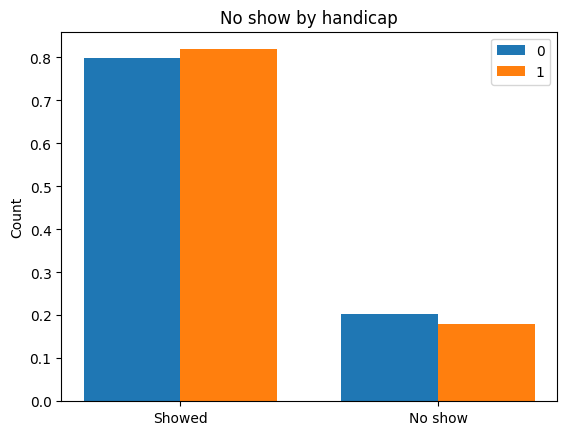

In [55]:
handicap_data = handicap_data.to_numpy()
handicap_data_norm = [x / x.sum() for x in handicap_data]
plot_grouped_bar(handicap_data_norm,
                 "No show by handicap",
                 group_labels=["Showed", "No show"],
                 category_labels=labels_handicap)

In [56]:
stat, p, dof, expected = chi2_contingency(handicap_data)
print("p-value: %f" % p)

p-value: 0.013288


Observations:
1. p-value < 0.05, showing there is relationship between handicap and no show rate.
2. Patients with handicap are more likely to show up.

## sms_received

If a patient received a SMS as reminder.

In [57]:
pd_sms_received = pd_data[["sms_received", "no_show"]].value_counts().unstack(fill_value=0)
print(pd_sms_received)

no_show          No    Yes
sms_received              
0             62509  12530
1             25698   9784


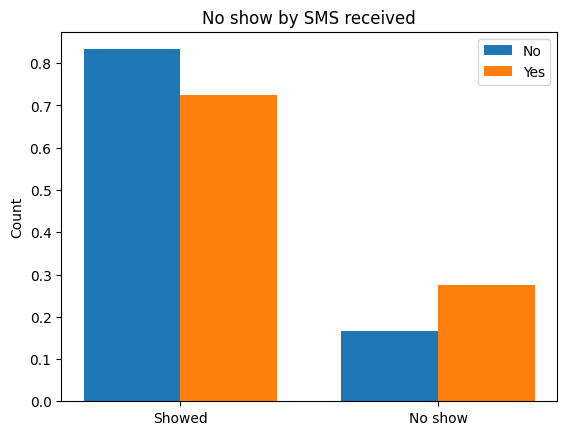

In [58]:
sms_received_data = pd_sms_received.to_numpy()
sms_received_data_norm = [x / x.sum() for x in sms_received_data]
plot_grouped_bar(sms_received_data_norm,
                 "No show by SMS received",
                 group_labels=["Showed", "No show"],
                 category_labels=["No", "Yes"])

In [59]:
stat, p, dof, expected = chi2_contingency(sms_received_data)
print("p-value: %f" % p)

p-value: 0.000000


Observations:
1. This field has negative effect, that is, patients received SMS are more likely to miss the appointment.
2. This is counterintuitive.

Based on previous observations, patients who made appointment same day are very likely to show up. So, another analysis without the same day appointment is conducted.

In [60]:
scheduled = pd_data["scheduled_day"]
appointment = pd_data["appointment_day"]
lag_days = (appointment - scheduled).dt.days
pd_sms_received = pd_data[["sms_received", "no_show"]]
pd_sms_received = pd_sms_received[lag_days > 0]
print(pd_sms_received)

        sms_received no_show
5                  0      No
6                  0     Yes
7                  0     Yes
9                  0      No
10                 0      No
...              ...     ...
110522             1      No
110523             1      No
110524             1      No
110525             1      No
110526             1      No

[71959 rows x 2 columns]


In [61]:
sms_received_data = pd_sms_received.value_counts().unstack(fill_value=0)
print(sms_received_data)

no_show          No    Yes
sms_received              
0             25739  10738
1             25698   9784


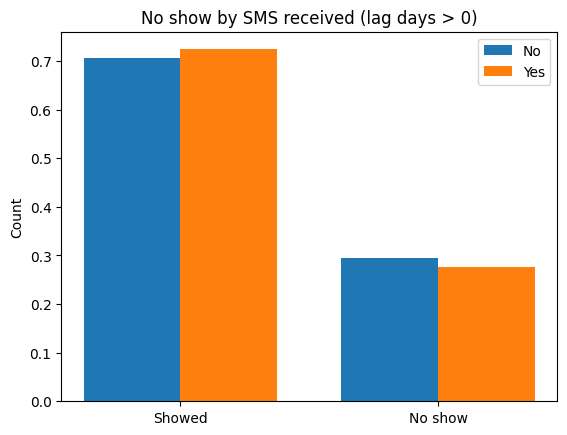

In [62]:
sms_received_data = sms_received_data.to_numpy()
sms_received_data_norm = [x / x.sum() for x in sms_received_data]
plot_grouped_bar(sms_received_data_norm,
                 "No show by SMS received (lag days > 0)",
                 group_labels=["Showed", "No show"],
                 category_labels=["No", "Yes"])

In [63]:
stat, p, dof, expected = chi2_contingency(sms_received_data)
print("p-value: %f" % p)

p-value: 0.000000


Observations:
1. Patients who received SMS are more likely to show up.